This is a python jupyter notebook for Digit Recognition Competition in Kaggle were the objective will not be only to develop a model, will also be analyze the features and compare a variety of models that can help to solve this challenge.

This notebook will be divided on the next sections:

 1. Intro 
 2. Data cleaning and Transformation
 3. Data Exploration 
 4. Data Modeling with
     4.1 Dimensionality Reduction
         4.1.1 PCA
         
     4.2 Classification
         4.2.1 Decision Tree
         4.2.2 Logistic Regression
         4.2.3 SVM
         4.2.4 Random Forest 
         4.2.5 Classifier Perceptron
 5. Comparation
 6. Conclusion

let's take on count that the predictive models might need different preprocessing steps, so I will use different dataframes if needed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec #to manipulate subplots grids
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, manifold, svm, tree, linear_model, metrics, ensemble
from sklearn.decomposition import PCA

### Intro

Data load and first look on the Dataset

In [2]:
df_digits = pd.read_csv('train.csv')
df_digits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [3]:
df_digits.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


So, we have 42000 rows with 785 features, the first feature is the digit that the image represent and  the others are pixel value of the image. Let's see how are the original images.

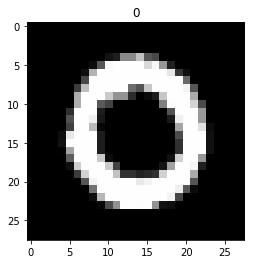

In [4]:
img = df_digits.iloc[1][1:].as_matrix()
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(df_digits.iloc[1,0])

So now let's plot only 9 images in a matrix

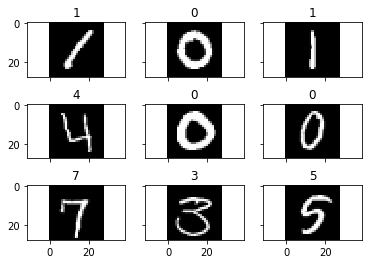

In [5]:
f, axarr = plt.subplots(nrows = 3, ncols=3, sharey = True, sharex= True)
i = 0
for ir in range(3):
    for ic in range(3):
        img = df_digits.iloc[i][1:].as_matrix()
        img = img.reshape((28,28))
        axarr[ir,ic].imshow(img,cmap = 'gray')
        axarr[ir,ic].set_title(df_digits.iloc[i,0])
        i+=1
f.subplots_adjust(hspace = 0.5)

We can see digits are centered, so we are guessing that the more dense pixel features will b the ones for the center of the picture and the less dense will be the ones that corresponds to the borders

### Data Cleaning and transformation

There is no need to transform the existent data due:
    
    1.- All the features are numeric, we don't have to parse features
    
    2.- We are guessing there are no missing data: the data are images converted to array
    
    3.- All the features have the same range of values, we can standarize but i will not do it yet.

### The exploration

In [6]:
df_features = df_digits.iloc[:,1:]
digits_labels = df_digits['label']

First, I want to know the distribution between the labels

(array([ 4132.,  4684.,  4177.,  4351.,  4072.,  3795.,  4137.,  4401.,
         4063.,  4188.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]),
 <a list of 10 Patch objects>)

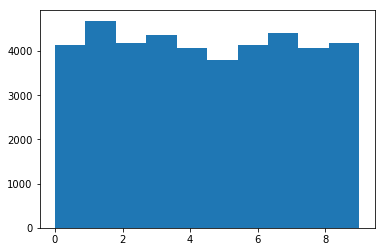

In [7]:
plt.hist(digits_labels)

Well, is a mostly equal distribution between the labels, so there shouldn't be a bias towards a certain digit

Now, I want to know how many pixels are not used in general

(array([  81.,   11.,    9.,    3.,   10.,    9.,    7.,    8.,    8.,  638.]),
 array([   0. ,   25.5,   51. ,   76.5,  102. ,  127.5,  153. ,  178.5,
         204. ,  229.5,  255. ]),
 <a list of 10 Patch objects>)

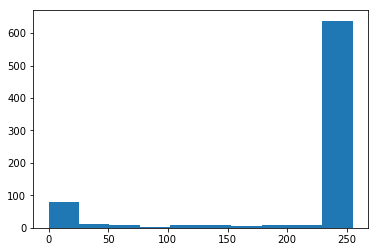

In [8]:
plt.hist(df_features.max())

We can see that are 81 are pixel not used in all the images (the first and second arrays are the qty and bin boundary values), but the great majority is used and have values greater than 229. This is not helpful.

Next, I want to check the average pixels usage for each digit in an image

C:\Users\sbanuelo\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


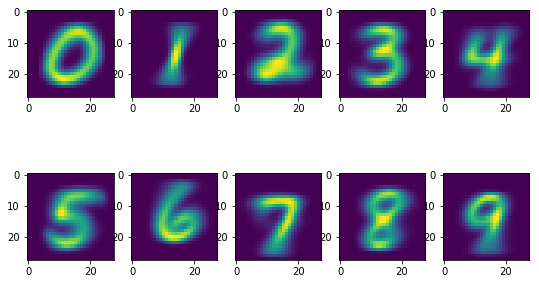

In [9]:
f, axarr = plt.subplots(2,5, figsize = (9,9))
gs1 = gridspec.GridSpec(2,5)
i=0
for ir in range(2):
    for ic in range(5):
        temp = df_features[digits_labels==i]   
        axarr[ir,ic].imshow(temp.mean().reshape(28,28))
        i+=1
f.subplots_adjust(hspace = -0.5)

it seems that 0,2,3,5,6,8,7 and 9 have very common pixel arrange, but for 1 and 4 there is not so defined.

Remember, we have 784 features representing pixel values, but not every pixel is used nor representative of a digit. So lets use dimensionality reduction to choose the most digit's representative features. 

But how many features do we need to have? We can try several options, so one of them is to count the average digit's pixels which have more than a certain value, like 200.

In [10]:
count, bins= np.histogram(df_features.mean(),bins = 14)
max(bins)

139.82614285714286

In [11]:
[x for x in zip(count, bins[1:])]

[(413, 9.9875816326530611),
 (49, 19.975163265306122),
 (35, 29.962744897959183),
 (27, 39.950326530612244),
 (25, 49.937908163265305),
 (22, 59.925489795918367),
 (20, 69.913071428571428),
 (31, 79.900653061224489),
 (28, 89.88823469387755),
 (38, 99.875816326530611),
 (30, 109.86339795918367),
 (29, 119.85097959183673),
 (25, 129.83856122448981),
 (12, 139.82614285714286)]

take in count that te bins array is bigger than the count array by 1, so I take from the second smallest bin boundary

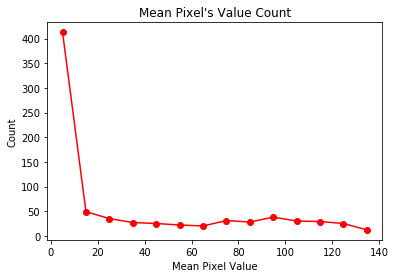

In [12]:
plt.plot(bins[1:]-5, count, 'ro-')
plt.title('Mean Pixel\'s Value Count')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Count')

In [13]:
sum(count[-2:])

37

So, from the 784 features using 14 bins, at least 400 features have values near to 0. Only 37 features have values greather than 119, so there is an option for the dimensional reduction. so lets use PCA for Exploratory Analysis using 35 features (for sake of the square like plots)

In [14]:
n_components = 35

### Training - test Split

In [15]:
sc = preprocessing.StandardScaler()
df_features_std = sc.fit_transform(df_features)
x_train, x_test, y_train, y_test = train_test_split(df_features_std, digits_labels, test_size = 0.25)

### Modeling: Dimensionality Reduction

#### Modeling PCA

In [16]:
pca_ = PCA(n_components=n_components)
pca_.fit(df_features, digits_labels)
eigen_val = pca_.components_.reshape(n_components, 28,28)

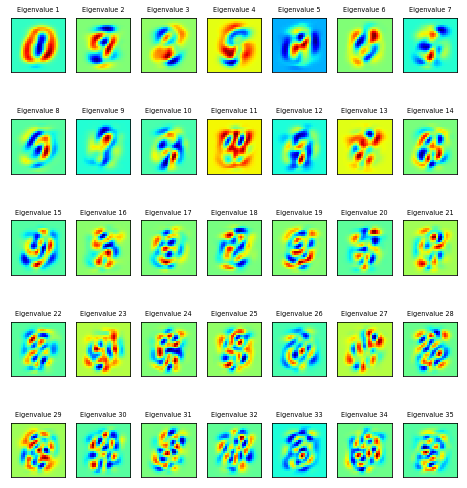

In [17]:
n_row = 5
n_col = 7
fig = plt.figure(figsize=(8,9))
for i in range(n_row * n_col):
    offset =0
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(eigen_val[i].reshape(28,28), cmap='jet')
    title_text = 'Eigenvalue ' + str(i + 1)
    plt.title(title_text, size=6.5)
    plt.xticks(())
    plt.yticks(())
plt.show()

we can see that the greater is the dimension the greater is the complexity.
I Will like to use 7, 21, 35 and 42 features to check their performance on PCA.

In [18]:
n_components_ = 7

In [19]:
from random import randint
colors = []
for i in range(10):
    colors.append('%06X' % randint(0, 0xFFFFFF))

In [20]:
pca_ = PCA(n_components=n_components_)
pca_features = pca_.fit_transform(x_train)
fig = plt.figure(figsize= (12,12))

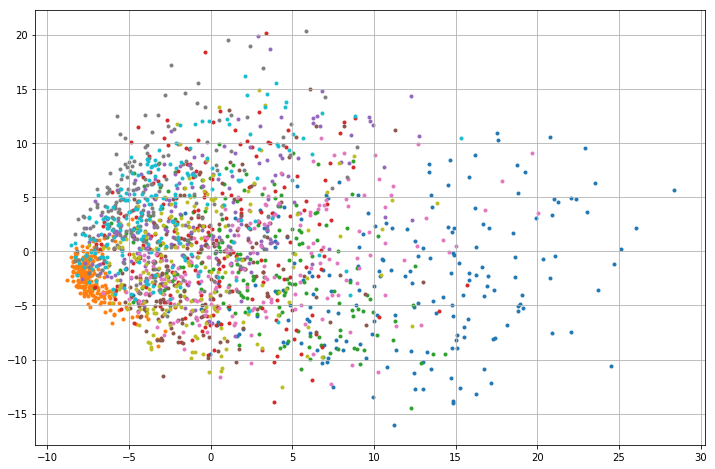

In [21]:
fig = plt.figure(figsize=(12,8))
for i in range(10):
    to_plot = pca_features[:2000,:2][y_train[:2000].values==i]
    plt.scatter(to_plot[:,0],to_plot[:,1], marker='.', cmap=colors[i])
    plt.grid(b='on')

we can see some clusters, but they aren't defined, so let's see how it work with the classifiers

In [22]:
clfs = [tree.DecisionTreeClassifier(), linear_model.LogisticRegression(),
        svm.SVC(C=1000.0), ensemble.RandomForestClassifier(),
        linear_model.Perceptron(n_iter=40, eta0=0.1, random_state = 0)]
n_components_ = [7,21,35,37]
clf_accu = np.zeros((len(clfs), len(n_components_)))
print('ready to learn')

ready to learn


In [23]:
for i,n_component_ in enumerate(n_components_):
    print('----- # of components: %d -----' % (n_component_))
    pca_ = PCA(n_components=n_component_)
    pca_features = pca_.fit_transform(x_train)
    pca_test = pca_.transform(x_test)
    for j,clf_ in enumerate(clfs):        
        clf_.fit(pca_features,y_train)
        y_pred = clf_.predict(pca_test)
        #print('Accuracy with %d components: %0.3f' % (n_components_,metrics.accuracy_score(y_test,y_pred)))
        clf_accu[j,i] = metrics.accuracy_score(y_test,y_pred)

----- # of components: 7 -----
----- # of components: 21 -----
----- # of components: 35 -----
----- # of components: 37 -----


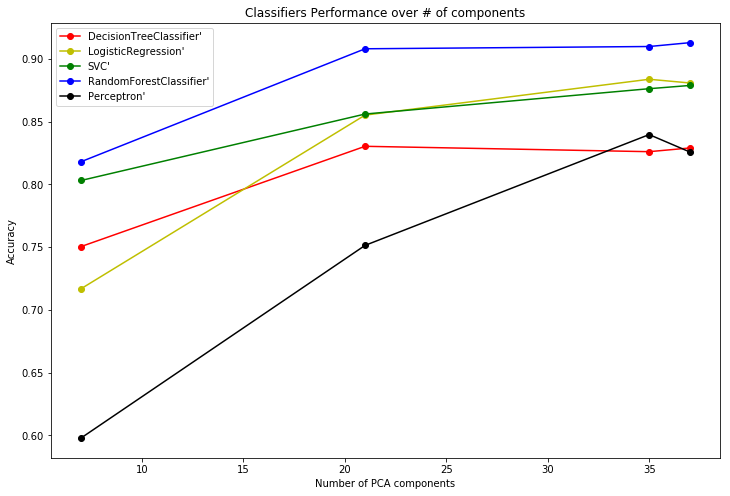

In [24]:
fig = plt.figure(figsize=(12,8))
colors = ['ro-','yo-','go-','bo-','ko-']
ax = fig.add_subplot(111)
legends = []
for i in range(len(clfs)):
    ax.plot(n_components_,clf_accu[i], colors[i])
    legends.append(str(type(clfs[i])).strip('>').split('.')[-1])
ax.set_title('Classifiers Performance over # of components')
ax.set_xlabel('Number of PCA components')
ax.set_ylabel('Accuracy')
ax.legend(legends)
plt.show()

#### Modeling ISOMAP

ISOMAP is a dimensionality reduction algorithm based on a neighbors kernel which let it to handle not linear models pretty well, grouping by pattern similarity on the variety of dimention. Take in count that, as PCA, there is not a rule to choose the number of neighbors, so it should be tested with different options. Let's try 5 neighbors (the greater the number, the heavier the computation and the same number of components for PCA

In [52]:
n_neighbors_ = [40]
n_components_ = [7,21,35]
clfs = [tree.DecisionTreeClassifier(), linear_model.LogisticRegression(),
       svm.SVC(C=1000.0), ensemble.RandomForestClassifier(),
        linear_model.Perceptron(n_iter=40, eta0=0.1, random_state = 0)]
clf_accu = np.zeros((len(clfs), len(n_components_)))
print('----Ready----')

----Ready----


In [ ]:
for n_n in n_neighbors_:
    print('----- Let\'s search for %d neighbors! -----' % (n_n))
    for i,n_component_ in enumerate(n_components_):
        print('\t ----for %d components----' % (n_component_))
        isomap_ = manifold.Isomap(n_neighbors=n_n, n_components= n_component_)
        isomap_features = isomap_.fit_transform(x_train[:15000])
        isomap_test = isomap_.transform(x_test)
        for j,clf_ in enumerate(clfs):
            print('\t    Working!')
            clf_.fit(isomap_features[:15000],y_train[:15000])
            y_pred = clf_.predict(isomap_test)
            #print('Accuracy with %d components: %0.3f' % (n_components_,metrics.accuracy_score(y_test,y_pred)))
            clf_accu[j,i] = metrics.accuracy_score(y_test,y_pred)
print('--------Complete!!-----------')

----- Let's search for 40 neighbors! -----
	 ----for 7 components----
	    Working!
	    Working!
	    Working!
	    Working!
	    Working!
	 ----for 21 components----
	    Working!
	    Working!
	    Working!
	    Working!
	    Working!
	 ----for 35 components----


In [ ]:
fig = plt.figure(figsize=(12,8))
colors = ['ro-','yo-','go-','bo-','ko-']
ax = fig.add_subplot(111)
legends = []
for i in range(len(clfs)):
    ax.plot(n_components_,clf_accu[i], colors[i])
    legends.append(str(type(clfs[i])).strip('>').split('.')[-1])
ax.set_title('Classifiers Performance over # of components')
ax.set_xlabel('Number of PCA components')
ax.set_ylabel('Accuracy')
ax.legend(legends)
plt.show()

In [42]:
clf_accu

array([[ 0.73180952,  0.74990476,  0.73247619],
       [ 0.74104762,  0.82028571,  0.83819048],
       [ 0.21      ,  0.20866667,  0.20695238],
       [ 0.80266667,  0.81914286,  0.81552381],
       [ 0.58761905,  0.71980952,  0.70904762]])